In [5]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import OneHotEncoder 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.model_selection import cross_val_score
from sklearn import metrics

C:\Users\Hugo\anaconda3\envs\Project\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
def convert_types(data):
    for column in data.columns:
        if data[column].dtype == np.int64:
            max_val = data[column].max()
            if max_val < 127:
                data[column] = data[column].astype(np.int8)
            elif max_val < 32767:
                data[column] = data[column].astype(np.int16)
            else:
                data[column] = data[column].astype(np.int32)
            
        if data[column].dtype == np.float64:
            data[column] = data[column].astype(np.float32)

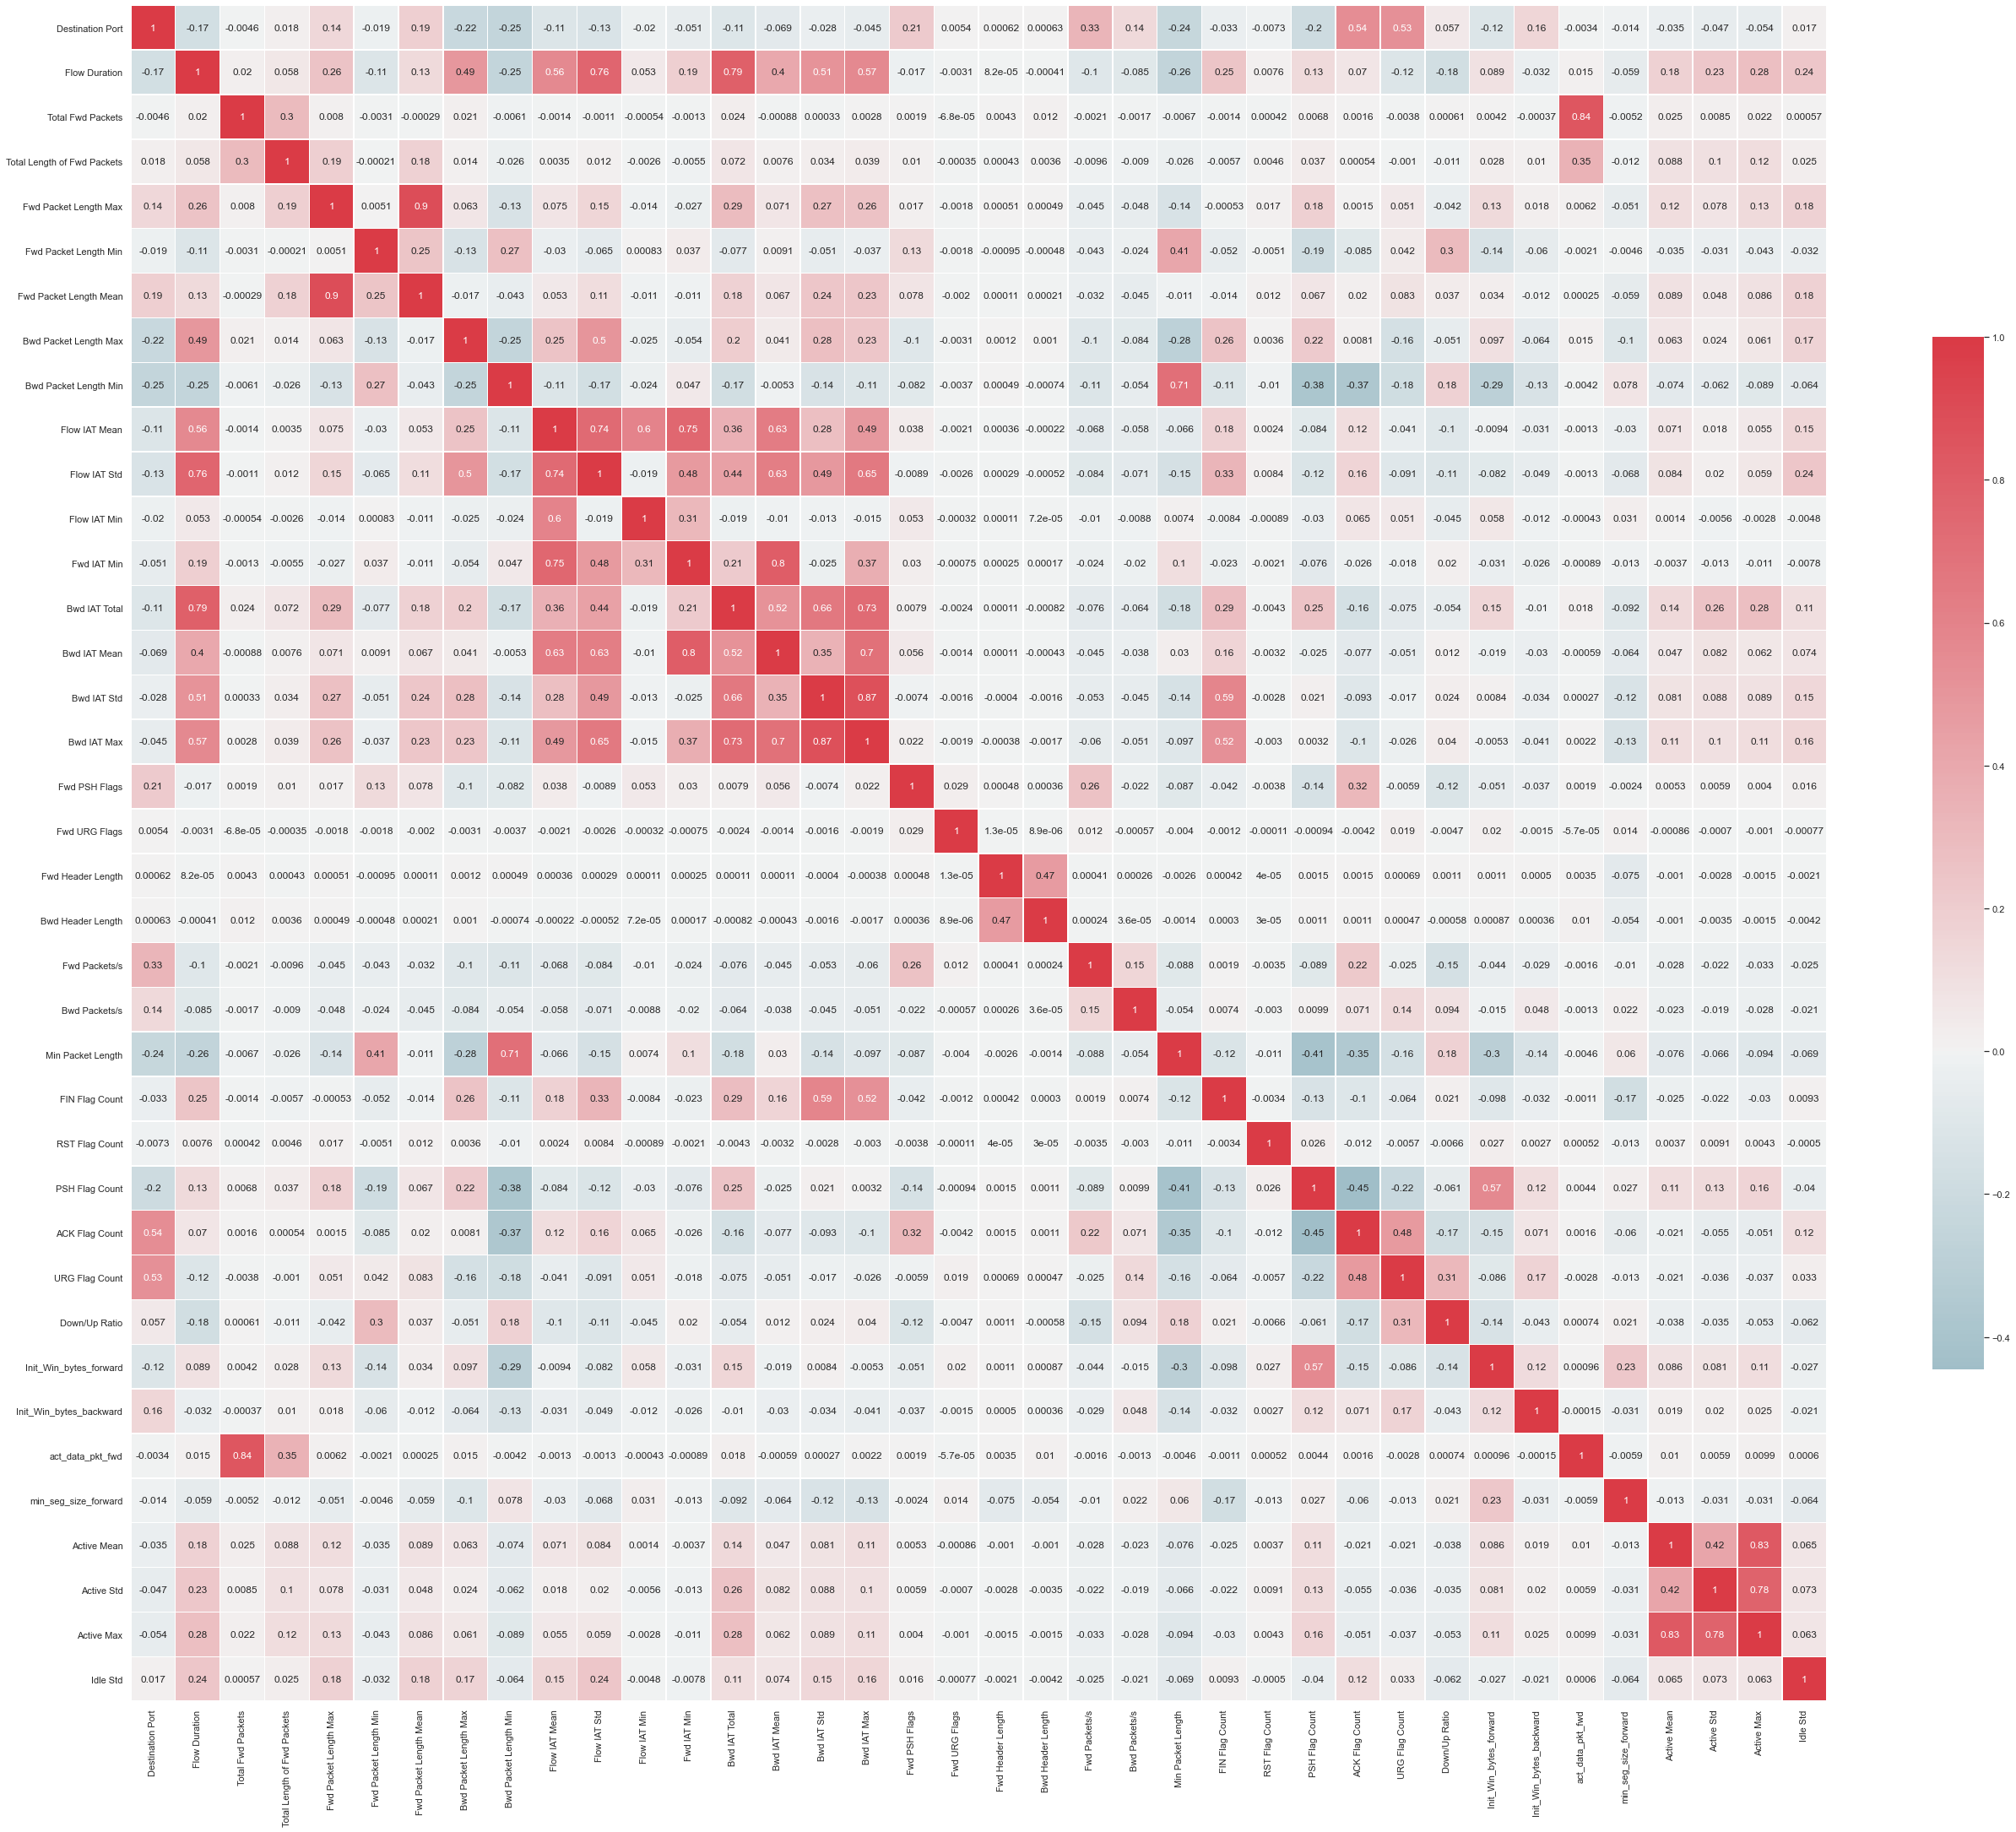

In [7]:
traffic = pd.read_csv("Data/Processed/processed_data.csv")
convert_types(traffic)
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = traffic.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(45,45))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

In [8]:
benign = traffic[traffic.Label == 'BENIGN'].sample(frac=0.1).reset_index(drop=True)
attack = traffic[traffic['Label'] != 'BENIGN']
traffic = pd.concat([attack, benign])
traffic = traffic[traffic.Label != 'Heartbleed']
traffic.Label.value_counts()

DoS             193748
BENIGN          159385
DDoS            128016
PortScan         90819
FTP-Patator       5933
SSH-Patator       3219
Web Attack        2143
Bot               1953
Infiltration        36
Name: Label, dtype: int64

In [9]:
y = traffic.Label
X = traffic.drop(['Label'],axis=1)

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

                          Specs         Score
10                 Flow IAT Std  75492.140659
1                 Flow Duration  64997.745056
7         Bwd Packet Length Max  62763.160435
26               PSH Flag Count  39894.709112
33         min_seg_size_forward  31043.077948
9                 Flow IAT Mean  24712.259072
8         Bwd Packet Length Min  21952.159717
23            Min Packet Length  20292.026585
24               FIN Flag Count  19960.828408
27               ACK Flag Count  15137.212190
3   Total Length of Fwd Packets  13817.087834
15                  Bwd IAT Std  13698.644827
16                  Bwd IAT Max  13315.969198
0              Destination Port  11558.060365
30       Init_Win_bytes_forward  11492.337494
13                Bwd IAT Total   9359.141428
22                Bwd Packets/s   8268.403015
31      Init_Win_bytes_backward   8072.454396
28               URG Flag Count   7173.478630
29                Down/Up Ratio   6005.389143
4         Fwd Packet Length Max   

In [10]:
feature = pd.DataFrame()
n = len(featureScores['Specs'])
for i in featureScores.nlargest(n//2,'Score')['Specs']:
        feature[i] = traffic[i]
feature['Label']= traffic.Label

In [11]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 585252 entries, 18600 to 159384
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Flow IAT Std                 585252 non-null  float32
 1   Flow Duration                585252 non-null  int32  
 2   Bwd Packet Length Max        585252 non-null  int16  
 3   PSH Flag Count               585252 non-null  int8   
 4   min_seg_size_forward         585252 non-null  int16  
 5   Flow IAT Mean                585252 non-null  float32
 6   Bwd Packet Length Min        585252 non-null  int16  
 7   Min Packet Length            585252 non-null  int16  
 8   FIN Flag Count               585252 non-null  int8   
 9   ACK Flag Count               585252 non-null  int8   
 10  Total Length of Fwd Packets  585252 non-null  int32  
 11  Bwd IAT Std                  585252 non-null  float32
 12  Bwd IAT Max                  585252 non-null  int32  


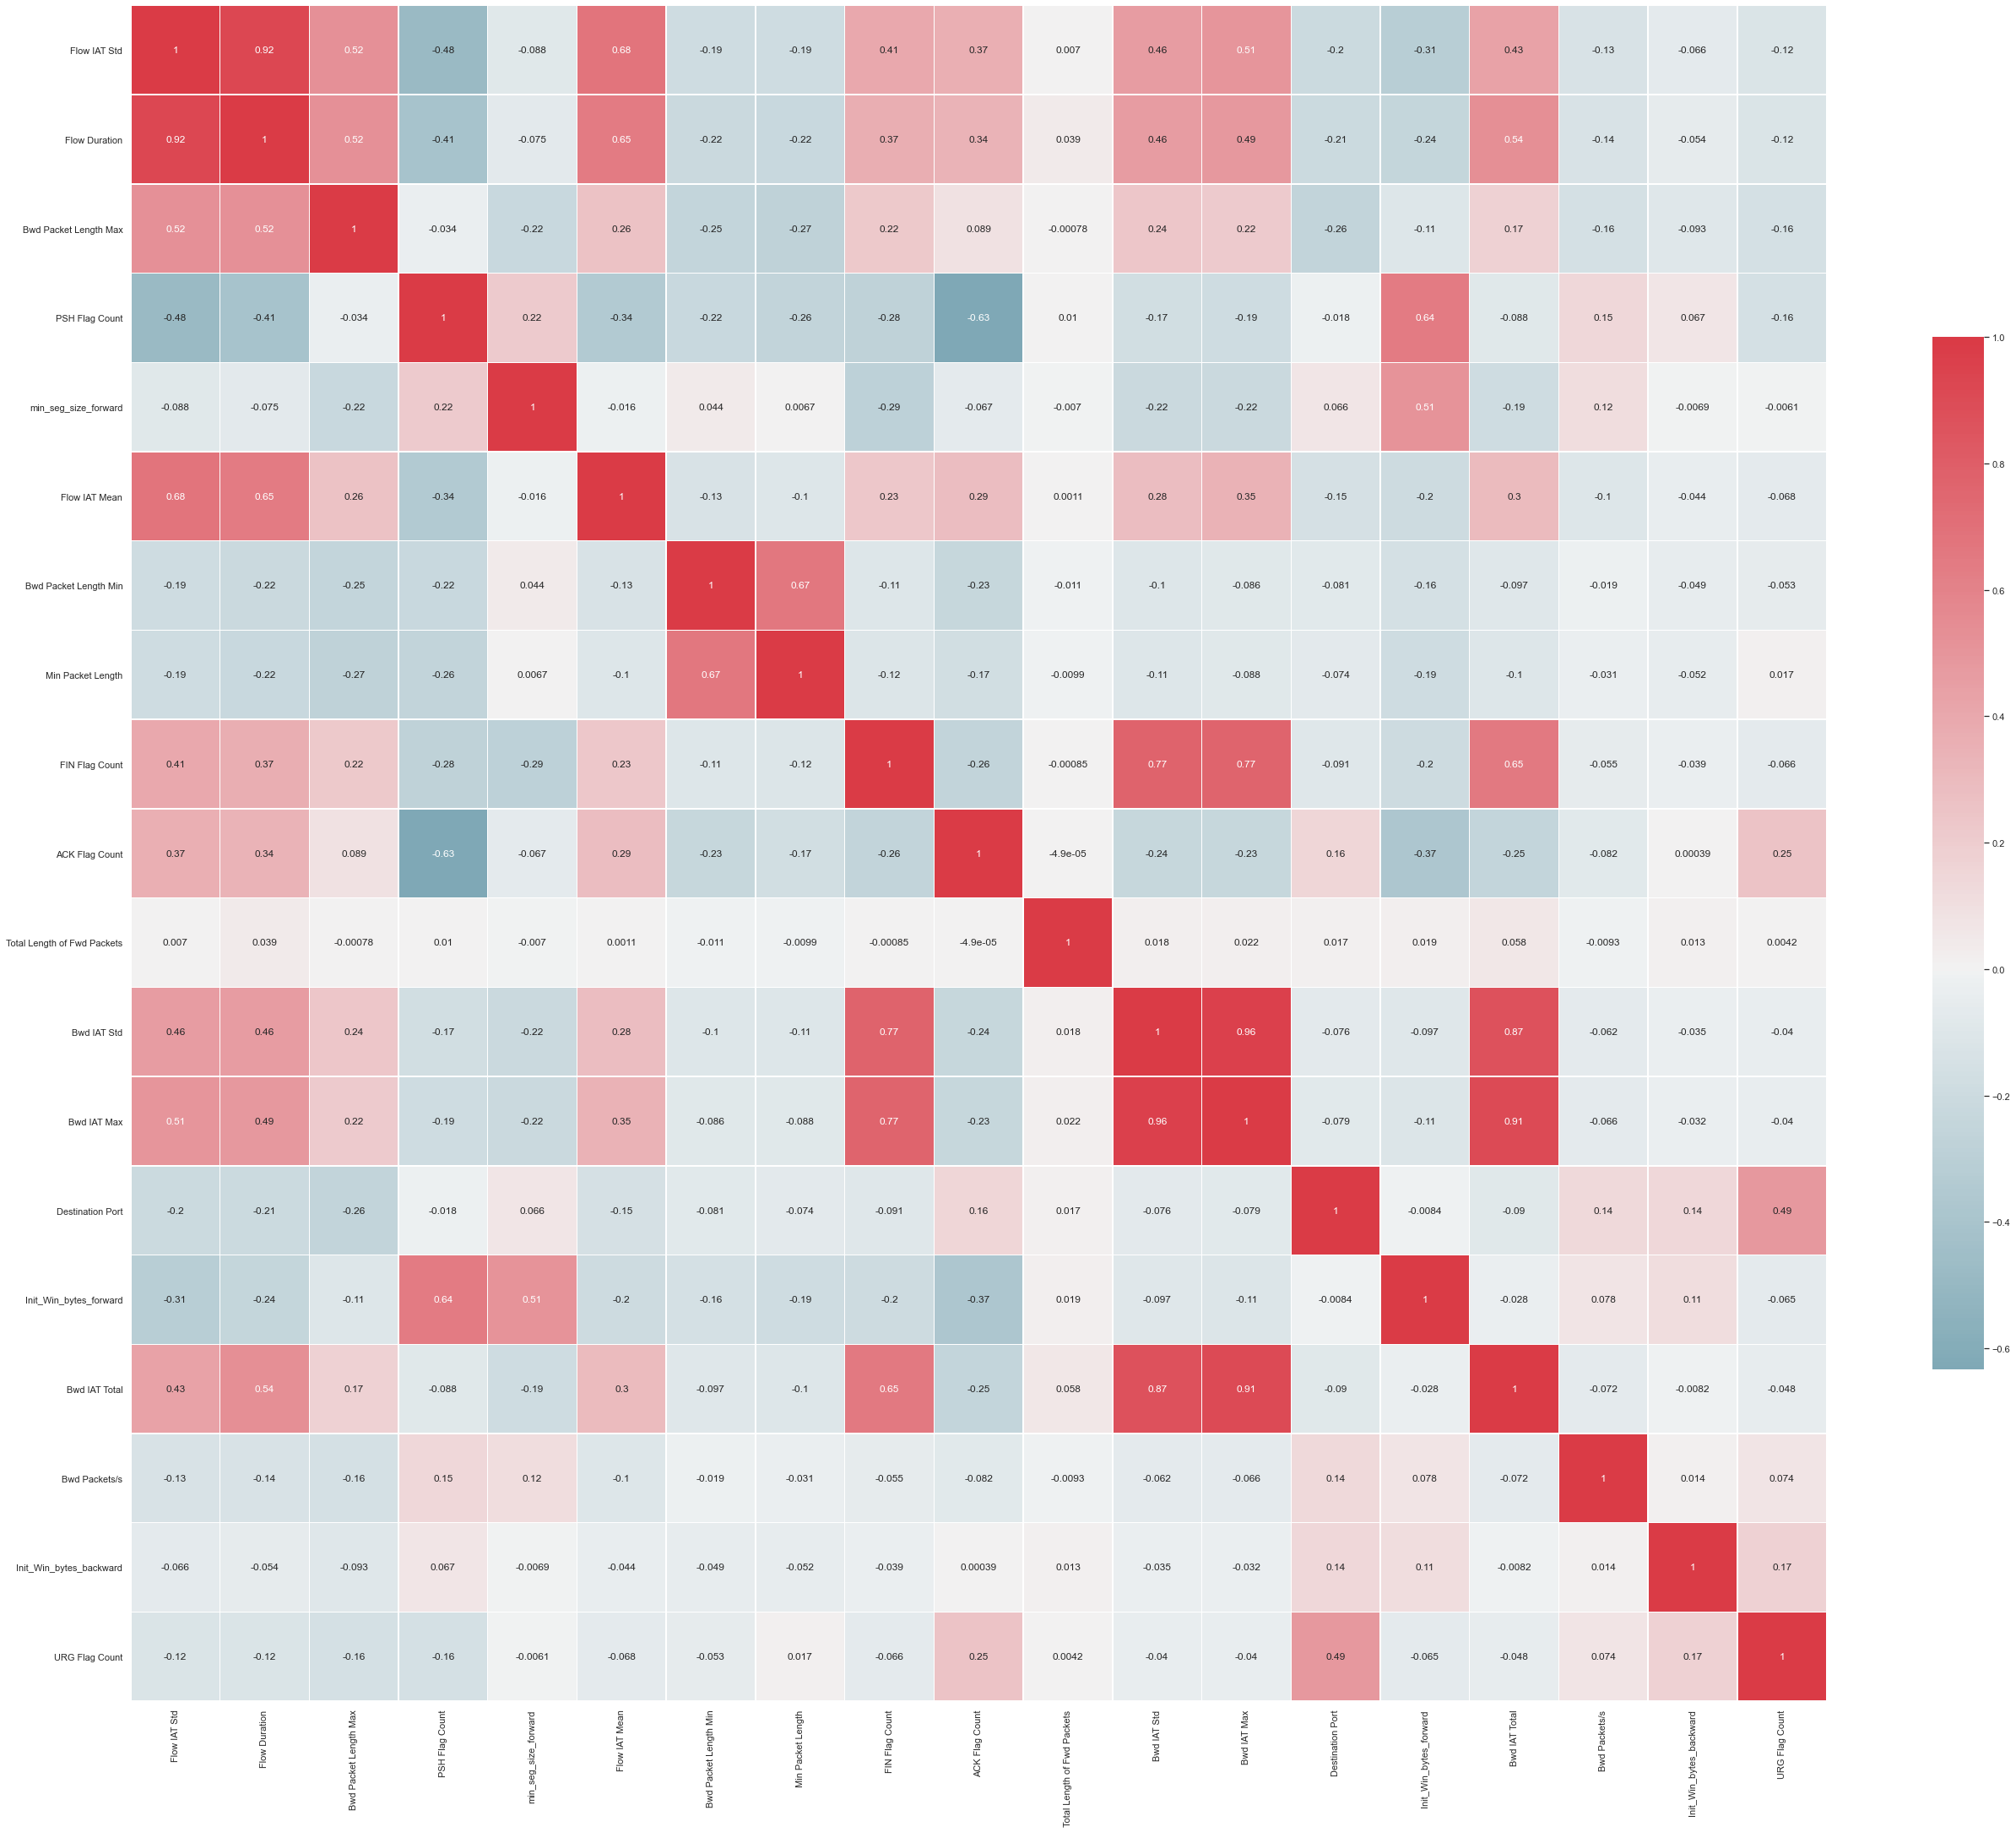

In [12]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = feature.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(45,45))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

In [13]:
feature.Label = feature.Label.astype('category')
feature.Label = feature.Label.astype("category").cat.codes

y = feature.Label
X = feature.drop(['Label'],axis=1)

In [14]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
#Scalling numerical attributes
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train_X.select_dtypes(include=['float32','float16','int32','int16','int8']).columns
sc_train = scaler.fit_transform(train_X.select_dtypes(include=['float32','float16','int32','int16','int8']))
sc_test = scaler.fit_transform(test_X.select_dtypes(include=['float32','float16','int32','int16','int8']))

# turn the result back to a dataframe
train_X = pd.DataFrame(sc_train, columns = cols)
test_X = pd.DataFrame(sc_test, columns = cols)

In [16]:
#Dataset Partition
X_train,X_test,Y_train,Y_test = train_test_split(train_X,train_y,train_size=0.7, random_state=42)

## Classifiers used:

    1. Decision Trees
    2. Gaussian Naive Baye Model
    3. Random Forest
    4. Logistic Regression

In [17]:
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train)

RTC_Classifier = RandomForestClassifier(criterion='entropy', n_jobs = -1)
RTC_Classifier.fit(X_train, Y_train)

BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)

LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train)

ADA_Classifier = AdaBoostClassifier(
    DTC_Classifier,
    n_estimators=100,
    learning_rate=1.5)

ADA_Classifier.fit(X_train, Y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         random_state=0),
                   learning_rate=1.5, n_estimators=100)

## Quantifying the quality of predictions

In [18]:
models = []
models.append(('Decision Tree Classifier', DTC_Classifier))
models.append(('Naive Baye Classifier', BNB_Classifier))
models.append(('Random Forest Classifier', RTC_Classifier))
models.append(('Logistic Regression Classifier', LGR_Classifier))
models.append(('AdaBoost Classifier', ADA_Classifier))

In [19]:
for i, model in models:
    scores = cross_val_score(model, X_train, Y_train, cv=5, n_jobs = 3)
    accuracy = metrics.accuracy_score(Y_train, model.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train, model.predict(X_train))
    classification = metrics.classification_report(Y_train, model.predict(X_train))
    print()
    print('############################## {} Model Evaluation ##############################'.format(i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


############################## Decision Tree Classifier Model Evaluation ##############################

Cross Validation Mean Score:
 0.9983959441948131

Model Accuracy:
 0.9999651292136986

Confusion matrix:
 [[77998     0     0     0     0     0     0     0     0]
 [    0   967     0     0     0     0     0     0     0]
 [    0     0 62773     0     0     0     0     0     0]
 [    2     0     0 95009     0     0     0     0     0]
 [    0     0     0     0  2840     0     0     0     0]
 [    0     0     0     0     0    15     0     0     0]
 [    8     0     0     0     0     0 44480     0     0]
 [    0     0     0     0     0     0     0  1579     0]
 [    0     0     0     0     0     0     0     0  1102]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77998
           1       1.00      1.00      1.00       967
           2       1.00      1.00      1.00     62773
           3       1.00      1.0